In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from common import *

set_random_seed(RANDOM_STATE)

In [2]:
import tensorflow as tf

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-15 16:53:32.109812: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 16:53:32.111769: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 16:53:32.111927: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [3]:
data              = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

In [4]:
%%time

MARKER      = -9999
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 144
SHUFFLE     = False
TEST_SIZE   = 0

# 1. Generate time
data_with_time = generate_full_timestamp(data)

# 2. Imputing
data_imp = impute_data(data_with_time)

# 3. Feature engineering
data_fe = feature_engineering(data_imp)

# 4. Smoothing
data_sm = smooth(data_fe, 'Patv')

# 5. Feature selection (select features)
cols = select_features(data_sm, threshold=0.2)

# 6. Split dataset
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data_sm, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)

# 7. Mark anomaly
# train_y_mark = copy(train_y)
#     for i in range(len(train_y)):
#         train_y_mark[i] = marking_data(train_y_mark[i], MARKER)

# val_y_mark = copy(val_y)
#     for i in range(len(val_y)):
#         val_y_mark[i] = marking_data(val_y_mark[i], MARKER)

# 8. Feature selection (apply)
train_x = [d[cols] for d in train_x]
train_y = [d[cols] for d in train_y]
# val_x   = [d[cols] for d in val_x]
# val_y   = [d[cols] for d in val_y]
test_x  = [d[cols] for d in test_x]
# train_y_mark = [d[cols] for d in train_y_mark]
# val_y_mark   = [d[cols] for d in val_y_mark]

# 9. Scaling
train_x_norm = np.array(train_x, dtype=np.float32)
train_y_norm = np.array(train_y, dtype=np.float32)
# val_x_norm   = np.array(val_x, dtype=np.float32)
# val_y_norm   = np.array(val_y, dtype=np.float32)
test_x_norm  = np.array(test_x, dtype=np.float32)

# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# train_x_norm = scaler.fit_transform(train_x_norm.reshape(-1, train_x_norm.shape[-1])).reshape(train_x_norm.shape)
# train_y_norm = scaler.fit_transform(train_y_norm.reshape(-1, train_y_norm.shape[-1])).reshape(train_y_norm.shape)
# val_x_norm   = scaler.transform(val_x_norm.reshape(-1, val_x_norm.shape[-1])).reshape(val_x_norm.shape)
# val_y_norm   = scaler.transform(val_y_norm.reshape(-1, val_y_norm.shape[-1])).reshape(val_y_norm.shape)

print("* Final data")
print("  - Train data(X, y)     :", np.shape(train_x), np.shape(train_y))
# print("  - Validation data(X, y):", np.shape(val_x),   np.shape(val_y))
print("  - Test data(X)         :", np.shape(test_x))

* Data name: Imputing
  - Number of data: 3823222
  - Number of nan rows: 0
* Data name: Smoothing
  - Number of data: 3823222
  - Number of nan rows: 0


100%|██████████| 134/134 [00:13<00:00, 10.30it/s]


* Data Split
  - Train data(X, y)     : (25553, 288, 46) (25553, 288, 46)
  - Validation data(X, y): (0,) (0,)
  - Test data(X)         : (134, 288, 46)
* Final data
  - Train data(X, y)     : (25553, 288, 20) (25553, 288, 20)
  - Test data(X)         : (134, 288, 20)
CPU times: user 1min 7s, sys: 6.63 s, total: 1min 14s
Wall time: 1min 2s


In [5]:
BATCH_SIZE = 64

train_ds = generate_dataset(train_x_norm, train_y_norm, batch_size=BATCH_SIZE, shuffle=True)
# val_ds   = generate_dataset(val_x, val_y, batch_size=BATCH_SIZE, shuffle=True)
test_ds  = generate_dataset(test_x_norm, batch_size=1)

2022-07-15 16:54:46.793752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-15 16:54:46.794537: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 16:54:46.794687: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-15 16:54:46.794784: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# 3. Modeling

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs
    
    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    x = layers.BatchNormalization()(x)
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
    for dim in mlp_units:
        x = layers.Dense(dim, activation='relu')(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(input_shape[-1])(x)
    return keras.Model(inputs, outputs)

In [7]:
from tensorflow.keras.metrics import RootMeanSquaredError

input_shape = np.shape(train_x)[1:]
model = build_model(input_shape,
                    head_size=8, num_heads=8, ff_dim=8, num_transformer_blocks=4, mlp_units=[128],
                    mlp_dropout=0.4, dropout=0.4)
model.compile(optimizer='adam', loss='mse', metrics=[RootMeanSquaredError(), 'mae'])

In [ ]:
model.summary()

# 4. Training

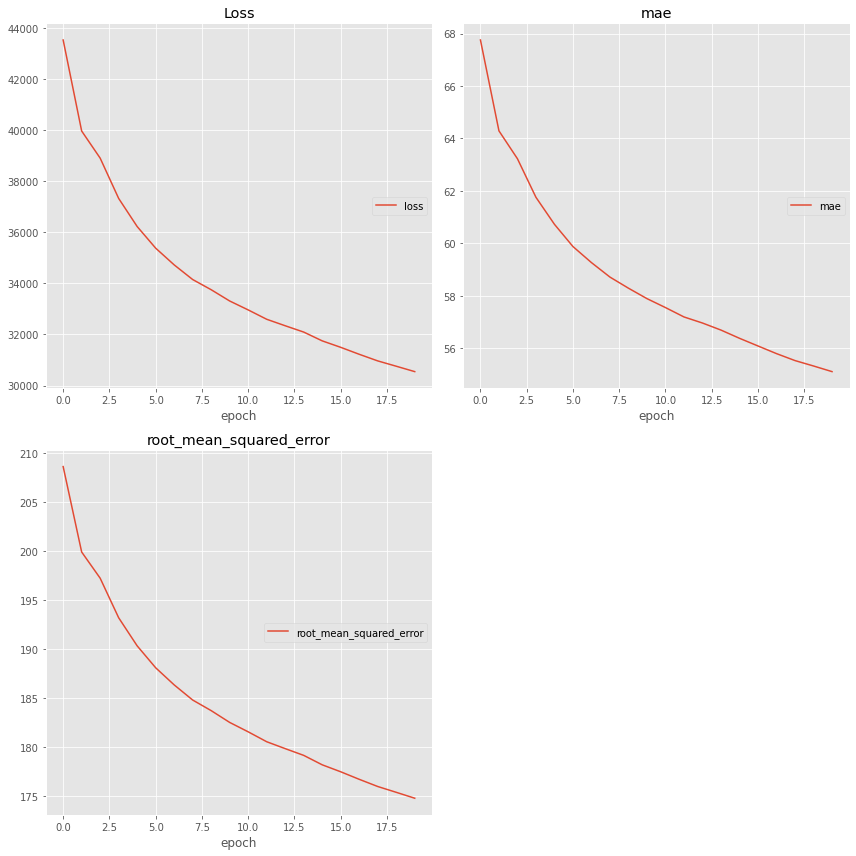

Loss
	loss             	 (min: 30543.738, max: 43528.496, cur: 30543.738)
mae
	mae              	 (min:   55.115, max:   67.754, cur:   55.115)
root_mean_squared_error
	root_mean_squared_error 	 (min:  174.768, max:  208.635, cur:  174.768)
400/400 [==============================] - 17s 41ms/step - loss: 30543.7383 - root_mean_squared_error: 174.7677 - mae: 55.1153


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

plt.style.use('ggplot')
model.fit(train_ds, epochs=20,
#           validation_data=val_ds,
          callbacks=[
              PlotLossesKeras(),
#               EarlyStopping(patience=10, restore_best_weights=True),
#               ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=3, verbose=1),
          ]);

# 5. Check results

## 1) Training set

799/799 [==============================] - 7s 8ms/step


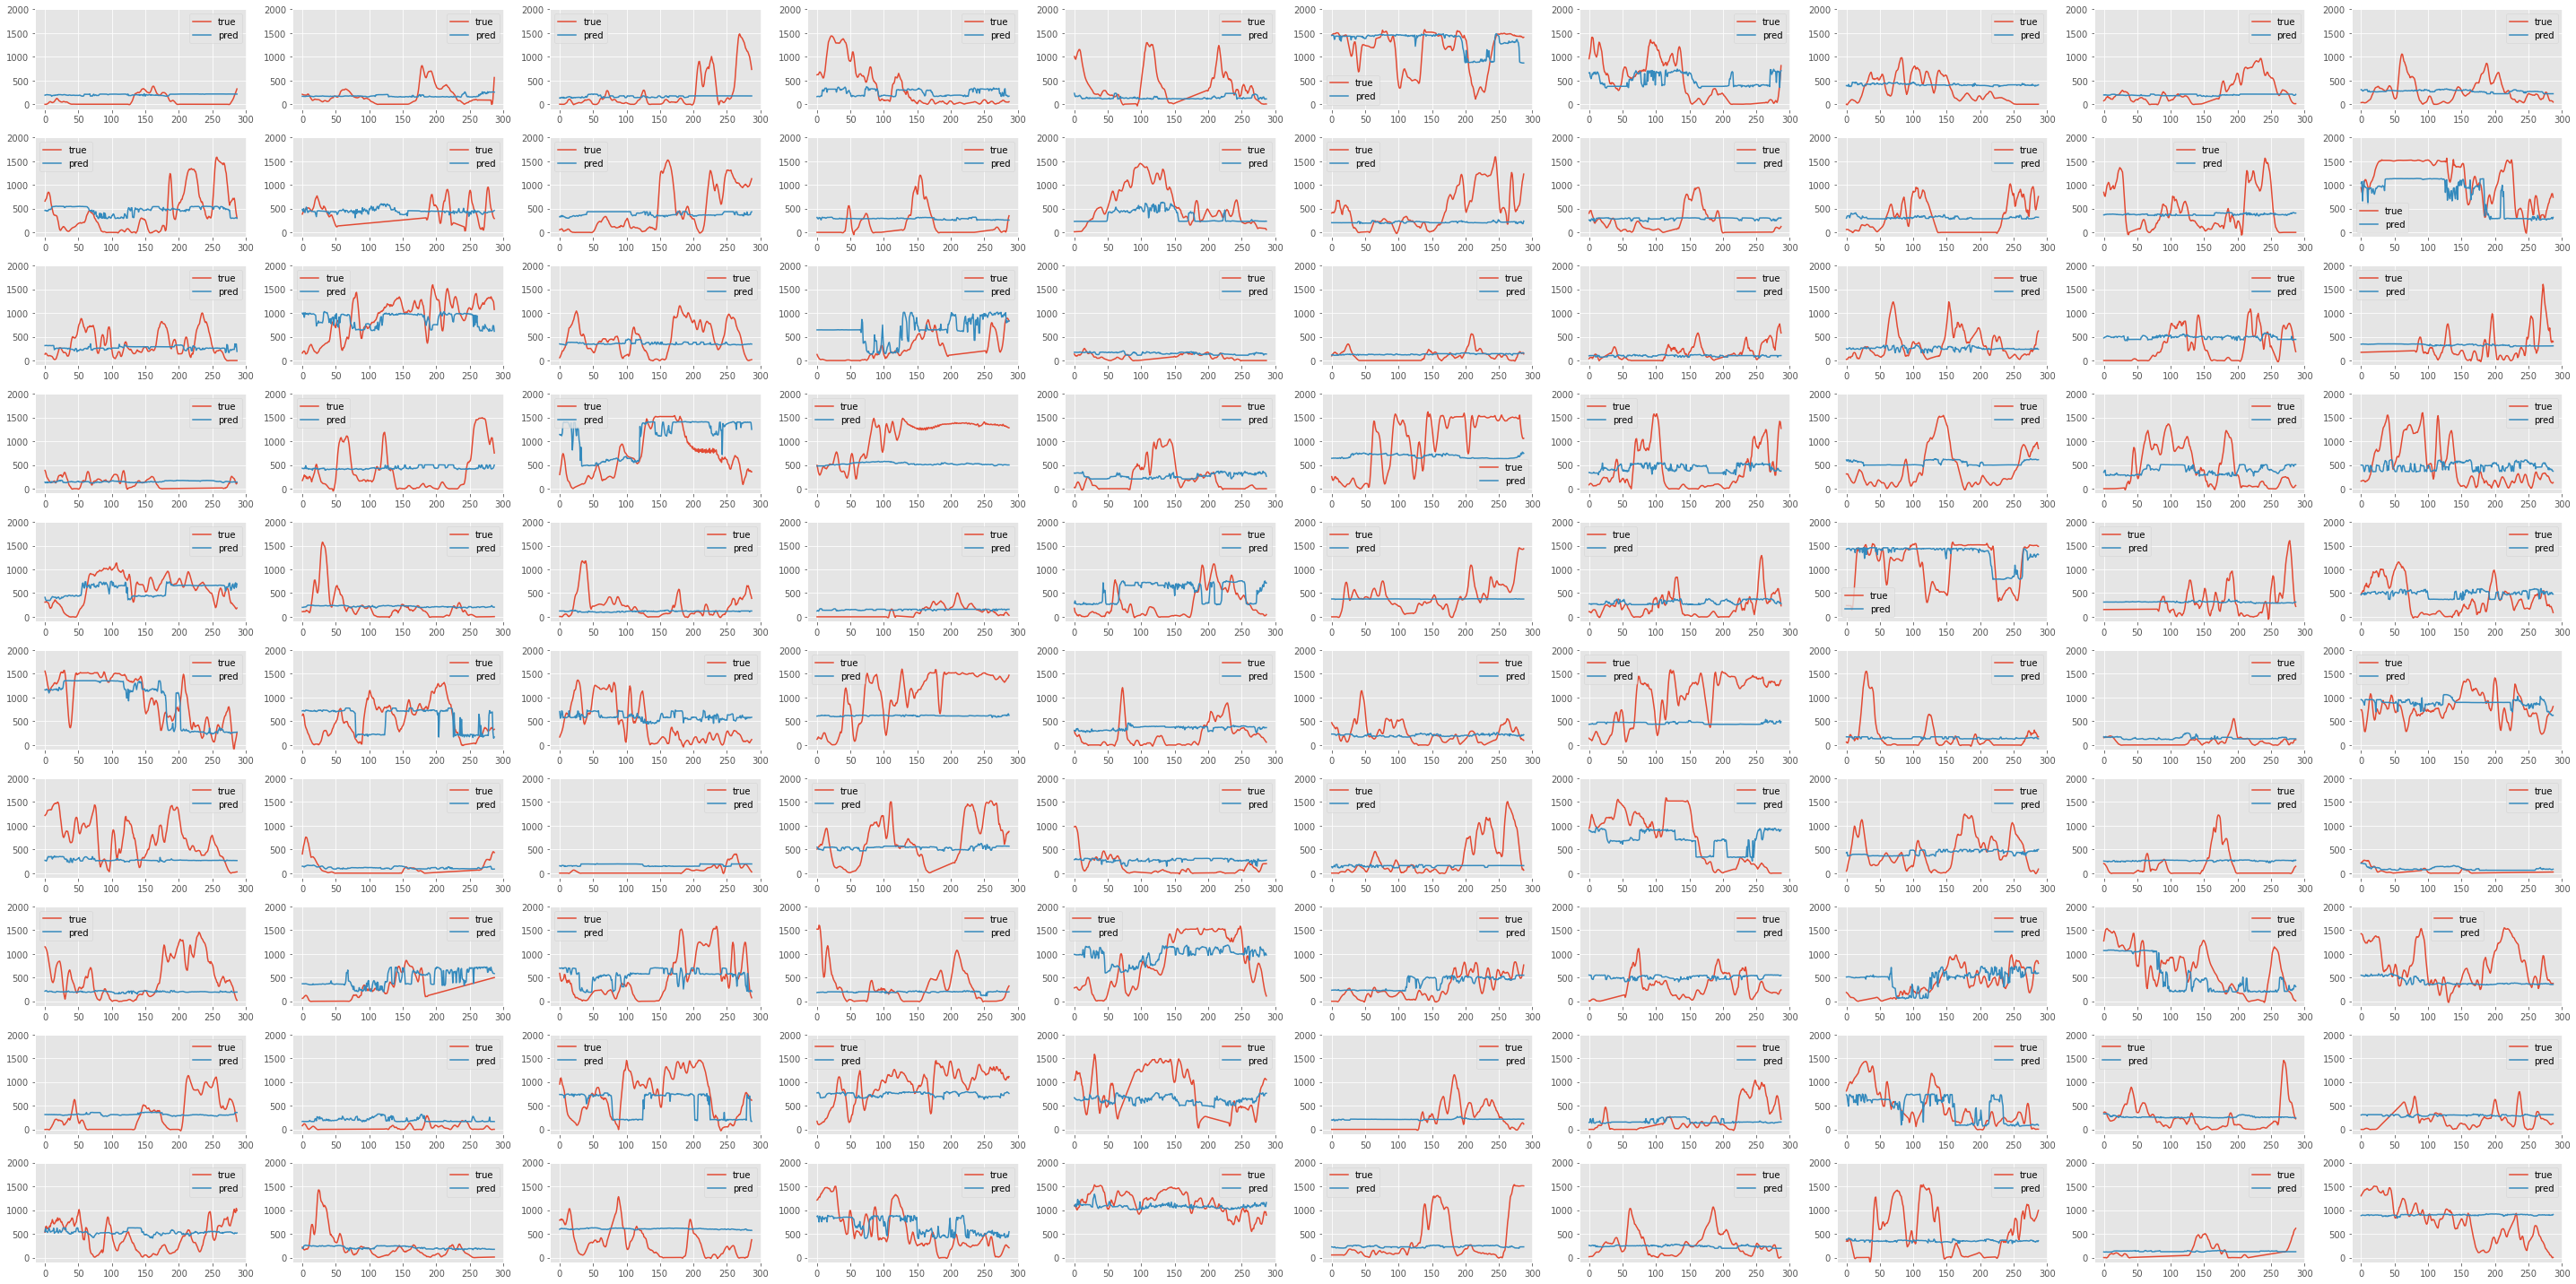

In [9]:
X      = train_x_norm
y_true = train_y_norm
y_pred = model.predict(X)

fig, axes = plt.subplots(10, 10, figsize=(40, 20))
idxs = np.random.choice(len(y_true), len(axes.flatten()))
for idx, ax in zip(idxs, axes.flatten()):
    pd.DataFrame({'true': y_true[idx, :, -1].reshape(-1),
                  'pred': y_pred[idx, :, -1].reshape(-1)}).plot(ax=ax, ylim=[-100, 2000])
fig.tight_layout()

# 6. Generate submission

In [10]:
X      = test_x_norm
y_pred = model.predict(X)

sample_submission['Patv'] = y_pred[:, :, -1].reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed17-BN.csv"), index=False)

5/5 [==============================] - 0s 9ms/step
